# Rock, Paper & Scissors with TensorFlow Hub - TFLite


This notebook will demonstrate how to take a trained TensorFlow model and save it as a TFLite model. The TFLite model is then something that can be deployed as part of a web application. (It'll also show you how you can use the tensorflow_datasets library, if you haven't seen that yet). 

This follows very closely the original Tensorflow Rock-Paper-Scissors TFHub + TFLite tutorial

##### Copyright 2018 The TensorFlow Authors.

```
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
```

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_lite/tflite_c06_exercise_rock_paper_scissors_solution.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_lite/tflite_c06_exercise_rock_paper_scissors_solution.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

## Part 1: Setup

1. Run the import statements and check versions. Check if GPU is available.

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

print("Tensorflow version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Tensorflow version:  2.8.0
Eager mode:  True
Hub version:  0.12.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available


2. Select the Hub/TF2 module to use.

    Note that hub modules for TF 1.x won't work. You can alternatively use one of the other options given for `model_selection`.

In [ ]:
module_selection = ("mobilenet_v2", 224, 1280) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE = "https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(
  MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280


## Part 2: Data preprocessing

1. Use [TensorFlow Datasets](http://tensorflow.org/datasets) to load the rock, paper and scissors dataset.

    This `tfds` package is the easiest way to load pre-defined data. If you have your own data, and are interested in importing using it with TensorFlow see [loading image data](../load_data/images.ipynb)

    The `tfds.load()` function downloads and caches the data and returns a `tf.data.Dataset` object. These objects provide powerful, efficient methods for manipulating data and piping it into your model.
    
    Since `"rock_paper_scissors"` doesn't define standard splits, use the subsplit feature to divide it into (train, validation, test) with 80%, 10%, 10% of the data respectively.

In [ ]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
splits, info = tfds.load('rock_paper_scissors',
                         with_info=True,
                         as_supervised=True,
                         split=['train[:80%]','train[80%:90%]','train[90%:]'])

Shuffling and writing examples to /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incompleteCFKBUY/rock_paper_scissors-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incompleteCFKBUY/rock_paper_scissors-test.tfrecord
Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.


2. Pull out the three subsets of the data from the `splits` variable and see the dimensions of the data.

In [ ]:
train_examples, validation_examples, test_examples = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

print("Number of training examples:", num_examples)
print("Number of classes:", num_classes)

Number of training examples: 2520
Number of classes: 3


3. Define the function `format_image()` to use the `tf.image` module to format the images for the task.

    Resize the images to a fixed input size, and rescale the input channels.

In [ ]:
def format_image(image, label):
    image = tf.image.resize(image, IMAGE_SIZE) / 255.0
    return image, label

4. Shuffle and batch the data, and apply the `format_image()` function to all the images. Follow the same syntax to create the `validation_batches` and `test_batches`. It's not necessary to shuffle the validation and test sets. For the `test_batches`, use a batch size of 1.

In [ ]:
BATCH_SIZE = 32 #@param {type:"integer"}

In [ ]:
train_batches = train_examples.shuffle(num_examples // 4).batch(BATCH_SIZE).map(format_image).prefetch(1)
validation_batches = validation_examples.batch(BATCH_SIZE).map(format_image).prefetch(1)
test_batches = test_examples.batch(1).map(format_image).prefetch(1)

5. Take a single batch from the training set and verify its dimensions.

    To get a single batch, use the `.take()` method with a count of 1. Then use `.get_single_element()` which will return the images for the batch and the labels for the bath. Print out the dimensions of the images for the batch.

In [ ]:
sbatch = train_batches.take(1).get_single_element()
sbatch[0][0].shape

TensorShape([224, 224, 3])

## Part 3: Defining and training the model

All it takes is to put a linear classifier on top of the `feature_extractor_layer` with the Hub module.

For speed, we start out with a non-trainable `feature_extractor_layer`, but you can also enable fine-tuning for greater accuracy.

1. Create the model according to the module handle defined above. Use a Sequential model with two layers:

    * `hub.KerasLayer`: a wrapper for a saved model. Give it these parameters:
        - `handle` - `MODULE_HANDLE` as defined above
        - `input_shape` - `IMAGE_SIZE` with an additional dimension for the 3 channels
        - `output_shape` - `FV_SIZE`, though make sure to make it into a tuple
        - `trainable` - `do_fine_tuning`
    * `Dense` - with `num_classes` units

In [ ]:
do_fine_tuning = True #@param {type:"boolean"}

print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential(
    [hub.KerasLayer(handle=MODULE_HANDLE,
                   input_shape=IMAGE_SIZE + (3, ),
                   output_shape=FV_SIZE,
                   trainable=do_fine_tuning),
                   tf.keras.layers.Dense(num_classes, activation='softmax')]
)
model.summary()

Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 2,261,827
Trainable params: 2,227,715
Non-trainable params: 34,112
_________________________________________________________________


2. Compile the model. You'll need to set three parameters:

    * `optimizer`: If `do_fine_tuning` is set to true, use `tf.keras.optimizers.SGD(lr=0.002, momentum=0.9)` as the optimizer, otherwise use `adam`.
    * `loss`: In both cases, use `tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)` as the loss function
    * `metrics`: In both cases, use accuracy as the metric.

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.002, momentum=0.9),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

3. Train the model and save the result as `hist`. Pass it both the training and validation data. Use the given number of epochs.

In [ ]:
EPOCHS = 5

hist = model.fit(
    train_batches,
    validation_data=validation_batches,
    epochs=EPOCHS,
)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


63/63 [==============================] - 30s 195ms/step - loss: 0.2103 - accuracy: 0.9549 - val_loss: 0.4717 - val_accuracy: 0.8294
Epoch 2/5
63/63 [==============================] - 13s 185ms/step - loss: 0.0863 - accuracy: 1.0000 - val_loss: 0.1761 - val_accuracy: 0.9802
Epoch 3/5
63/63 [==============================] - 14s 196ms/step - loss: 0.0848 - accuracy: 1.0000 - val_loss: 0.0929 - val_accuracy: 1.0000
Epoch 4/5
63/63 [==============================] - 13s 184ms/step - loss: 0.0845 - accuracy: 1.0000 - val_loss: 0.0846 - val_accuracy: 1.0000
Epoch 5/5
63/63 [==============================] - 13s 183ms/step - loss: 0.0842 - accuracy: 1.0000 - val_loss: 0.0839 - val_accuracy: 1.0000


## Part 4: Export the model

1. If you're running in Colab, mount the drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


2. Create the path to where you want the model saved. Feel free to modify the path given.

In [ ]:
import os

RPS_SAVED_MODEL = "rps_saved_model"
model_save_path = '/content/drive/MyDrive/FourthBrain/Assignments/Week_11/'
full_model_save_path = os.path.join(model_save_path, RPS_SAVED_MODEL)

3. Export the saved model using the `tf.saved_model.save()` function. You will need to pass it the model and the path.

In [ ]:
tf.saved_model.save(model, full_model_save_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/FourthBrain/Assignments/Week_11/rps_saved_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/FourthBrain/Assignments/Week_11/rps_saved_model/assets


4. Use the CLI to get the specs of the saved model.

In [ ]:
%%bash -s $full_model_save_path
saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['keras_layer_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 224, 224, 3)
      name: serving_default_keras_layer_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 3)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


5. Load the model using the `tf.saved_model.load()` function and run the print statements to see some stats on the model.

In [ ]:
loaded = tf.saved_model.load(full_model_save_path)

print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'keras_layer_input': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_layer_input')})
{'dense': TensorSpec(shape=(None, 3), dtype=tf.float32, name='dense')}


## Part 5: Convert with TFLiteConverter

1. Use the `TFLiteConverter` to convert the saved model to a Tensorflow Lite model. Use the `tf.lite.TFLiteConverter.from_saved_model()` function to create a converter and save it as `converter`. Set `converter.optimizations` to `[tf.lite.Optimize.DEFAULT]`.

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(full_model_save_path)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

2. Use the `converter.convert()` method to convert the model and save the result in `tflite_model_save_path`.

In [ ]:
tflite_model_save_path = os.path.join(model_save_path, "converted_model.tflite")
with open(tflite_model_save_path, "wb") as f:
    f.write(converter.convert())

3. Test the TFLite model using the Python Interpreter. Randomly sample some test images to test with.

In [ ]:
tflite_model_file = os.path.join(model_save_path, 'converted_model.tflite')
with open(tflite_model_file, 'rb') as fid:
    tflite_model = fid.read()

interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [ ]:
from tqdm import tqdm

predictions = []

test_labels, test_imgs = [], []
for img, label in tqdm(test_batches.take(10)):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))
    test_labels.append(label.numpy()[0])
    test_imgs.append(img)

100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


4. Define the `plot_image()` function and use it to draw the image.

In [ ]:
#@title Utility functions for plotting
# Utilities for plotting
import matplotlib.pyplot as plt
import numpy as np

class_names = ['rock', 'paper', 'scissors']

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    img = np.squeeze(img)

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    print(type(predicted_label), type(true_label))
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
  
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                  100 * np.max(predictions_array),
                                  class_names[true_label]),
                                  color=color)

<class 'numpy.int64'> <class 'numpy.int64'>


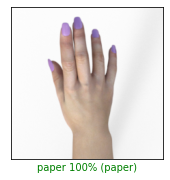

In [ ]:
#@title Visualize the outputs { run: "auto" }
index = 0 #@param {type:"slider", min:0, max:9, step:1}
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plot_image(index, predictions, test_labels, test_imgs)
plt.show()